## Mean Reversion and Stationarity

### Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

In [48]:
data = yf.download('EURUSD=X', start='2000-01-01')
data = data[['Close']]
data = data.dropna()

print(data.head())

[*********************100%%**********************]  1 of 1 completed
               Close
Date                
2003-12-01  1.196501
2003-12-02  1.208897
2003-12-03  1.212298
2003-12-04  1.208094
2003-12-05  1.218695


### Visualize Close Prices

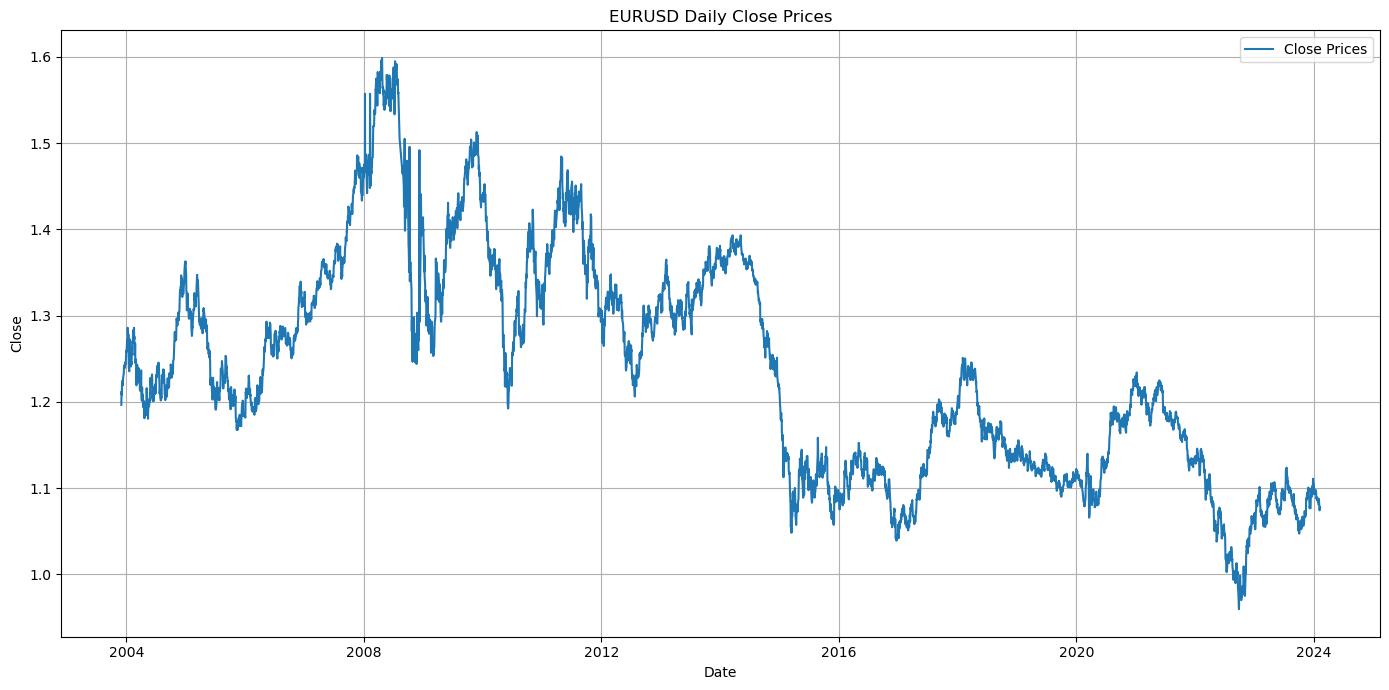

In [49]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Prices')
plt.title('EURUSD Daily Close Prices')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### ADF Test

In [50]:
data_cleaned = data.dropna()

result = adfuller(data_cleaned['Close'], regression='c', maxlag=1, autolag=None)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Number of Lags:', result[2])
print('Number of Observations:', result[3])
print('Critical Values:', result[4])

ADF Statistic: -2.002563430713626
p-value: 0.28545025650042855
Number of Lags: 1
Number of Observations: 5239
Critical Values: {'1%': -3.431598808349038, '5%': -2.862091843792385, '10%': -2.567063746167403}


ADF Test Statistic > Critical Value for 1%, 5%, 10%   ->    EUR/USD Conversion is not stationary 

### Hurst Exponent

In [51]:
from hurst import compute_Hc

H, c, data_reg = compute_Hc(data_cleaned['Close'], kind='price', simplified=True)
print("\nHurst exponent:", H)


Hurst exponent: 0.4934158538061741


Hurst exponent is very slightly mean-reverting, but not enough.

### Variance Ratio Test

In [52]:
from arch.unitroot import VarianceRatio

vr = VarianceRatio(data_cleaned['Close'], 2)
print("\nVariance Ratio Test:\n", vr.summary().as_text())


Variance Ratio Test:
      Variance-Ratio Test Results     
Test Statistic                 -1.938
P-value                         0.053
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


The Variance Ratio Test p-value tells us there is a 53% chance that the EUR/USD rate is a random walk (null hypothesis).

### Half-Life of Mean Reversion 

In [53]:
import statsmodels.api as sm

delta_y = data_cleaned.diff().dropna()
lagged_data = data_cleaned.shift(1).dropna()

delta_y = delta_y['Close']
lagged_data = lagged_data['Close']
delta_y = pd.to_numeric(delta_y, errors='coerce')
lagged_data = pd.to_numeric(lagged_data, errors='coerce')
delta_y = delta_y.dropna()
lagged_data = lagged_data.dropna()

# Regression
exog = sm.add_constant(lagged_data)
model = sm.OLS(delta_y, exog)
results = model.fit()

lambda_val = results.params[1]

half_life = -np.log(2) / lambda_val

print(f"Lambda (speed of mean reversion): {lambda_val}")
print(f"Half-life of mean reversion: {half_life}")

Lambda (speed of mean reversion): -0.0026279498789142388
Half-life of mean reversion: 263.759665327531


C:\Users\Arjun\AppData\Local\Temp\ipykernel_13060\2308499954.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda_val = results.params[1]


Lambda, which means the half-life is very long and a strategy would not be profitable, because we won’t be able to complete many round-trip trades in a given time period.
Indeed, the half-life of the mean reversion is 263 days    ->     gives us insight into holding period.